# 3. Feature Engineering and EDA Part II: Textual Data


In this notebook, we'll carry on with feature engineering textual data.

Again, we will use interactive plots for our numerical data. **You'll be able to zoom in and mouse over the distributions to see value counts.**

**For the visualizations to work, please install the libraries at your command line/terminal using:**

    pip install plotly
    pip install cufflinks
    pip install squarify

In [1]:
#the usual dataframe and visualization imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#plotly, squarify and cufflinks interactive chart imports

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.express as px #another related library of plotly that makes it easy to draw multiple plots
import squarify

#we have to make sure this code is run for Jupyter Notebooks otherwise the plots may not happen offline:
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
#we're gonna have to read a lot of words in columns, so let's expand the column width again:
pd.set_option("display.max_colwidth", 500)

In [3]:
#reading our dataframe again

df=pd.read_csv("../data/df_clean.csv")

df.columns

Index(['title', 'link_flair_text', 'selftext', 'score', 'url', 'num_comments',
       'subreddit'],
      dtype='object')

So far we have only looked at general continuous numerical data that provides us with simple insights into subreddit member engagement. But what do users in each subreddit actually talk about? Well, we already found a feature in the previous section that helps us measure topic category trends:

In [51]:
#Plot subreddit topic  "flair" categories on a plotly bar chart by frequency of words.

flair_cats=df["link_flair_text"].value_counts()

fig = px.bar(flair_cats, orientation='v', title = "Most Discussed General Topics")
fig.show()

This isn't very helpful as we simply see that the top 5 topics are very broad - General Discussions, Questions, Career and Education and projects.

**In order to deep dive into specific subjects to answer the problem statement, we will conduct key-word analysis and visualizations**. To do this, we will need to prepare our words to become machine-readable.

## Word Pre-Processing

For our columns `title` and `selftext`, we will need to convert the text into a "bag of words" i.e. unique words in a text represented by a number. To facilitate this we must first pre-process by 

    1. getting rid of punctuation and non-words using RegEx, 
    2. lowercasing everything, 
    3. removing "stop words" i.e. conjunctive/article type words with no substantial meaning for content, 
    4. lemmatizing e.g. contracting words like run/ran/runs into run.

RegEx has to be installed via `pip install regex`

In [4]:
#this requires new imports for our custom function:

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import regex as re

In [5]:
#instantiate the lemmatizer

lemmatizer = WordNetLemmatizer()

In [6]:
#adapted from GA tutorial:

def word_cleaner(mess):
    
    #removing non-letters including spaces
    just_letters = re.sub("[^a-zA-Z]", " ", mess)
    
    #lower-casing
    small_caps = just_letters.lower().split()
    
    #assign stopwords into a set and then removing those from target text
    stops = set(stopwords.words('english'))
    important_words = [string for string in small_caps if not string in stops]
    
    #lemmatize the important words 
    lem_words_only = [lemmatizer.lemmatize(word) for word in important_words]

    #rejoin all the words into a string separated by a space
    return(" ".join(lem_words_only))

In [7]:
#using .apply to run the function across the whole selftext column

df['selftext'].apply(word_cleaner)

0       quite change subreddit past couple year behind scene visibly mod team thought would good time discus vision subreddit get feedback change moderation generally vision extent vision subreddit perhaps easier define trying rather want trying place academic technical discussion since subreddits like r machinelearning r askstatistics r python already cover area specifically trying place learning transitioning getting job data science since countless blog website discussing trying place people comp...
1                                                                                                                                                                                                                                                                                             let say interview talk current work normal let say interviewer deep dive current work tempted discus insight gained outcome model appropriate seen divulging proprietary company info therefore might actually

In [8]:
#creating a new, cleaned column to put into our dataframe

df['cleaned_text']=df['selftext'].apply(word_cleaner)

In [10]:
#comparing our cleaned vs messy selftext columns to see what the change looks like
df.loc[1284:1285,['selftext','cleaned_text']].head()

,selftext,cleaned_text
1284,Hello All!\n\nI'm working on developing some initial plans to begin using Google Optimize along with GA360 which my company already has. One question that I am still trying to clarify is what is typically done to keep experiment data out of the main GA data pool. \n\nI'm trying to avoid a situation where I have to explain that the reason conversions for a specific metric fell during a week where we were testing a new design and some users had a different experience. \n\nDo people typically j...,hello working developing initial plan begin using google optimize along ga company already one question still trying clarify typically done keep experiment data main ga data pool trying avoid situation explain reason conversion specific metric fell week testing new design user different experience people typically filter based experiment variant id special view
1285,"Hi guys\n\nCurrently, we're facing a big discrepancy between the metrics for link clicks we see on various platforms (Facebook, Twitter, YouTube, LinkedIn) and the number of sessions we're tracking in Google Analytics.\n\nWe're aware that typically GA shows fewer sessions, e.g. because people jump off before the page loads, don't accept the tracking of cookies, etc. However, the discrepancy is so big (*4 or 5 times*) that we feel this doesn't explain it. On Twitter, for example, the differen...",hi guy currently facing big discrepancy metric link click see various platform facebook twitter youtube linkedin number session tracking google analytics aware typically ga show fewer session e g people jump page load accept tracking cooky etc however discrepancy big time feel explain twitter example difference around link click v session ga also indicator problem bigger session recorded mobile tracked desktop device would anybody idea could find problem know good article help troubleshootin...


In [11]:
#our function worked as intended. let's repeat the process for title:

df['title'].apply(word_cleaner)
df['cleaned_title']=df['title'].apply(word_cleaner)
df.loc[1284:1285,['title','cleaned_title']].head()

#that looks good too, on to Word Vectorization 

,title,cleaned_title
1284,Google Optimize &amp; Google Analytics best practices for segmenting experiment data?,google optimize amp google analytics best practice segmenting experiment data
1285,"Big discrepancy between GA and advertising platform (FB, TW, YT, LI)",big discrepancy ga advertising platform fb tw yt li


In [12]:
df.info()

#no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286 entries, 0 to 1285
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            1286 non-null   object
 1   link_flair_text  1286 non-null   object
 2   selftext         1286 non-null   object
 3   score            1286 non-null   int64 
 4   url              1286 non-null   object
 5   num_comments     1286 non-null   int64 
 6   subreddit        1286 non-null   object
 7   cleaned_text     1286 non-null   object
 8   cleaned_title    1286 non-null   object
dtypes: int64(2), object(7)
memory usage: 90.5+ KB


In [13]:
#backing up this dataframe in case things go horribly long in Word Vectorization

df.to_csv("../data/df_processed.csv", index=False)

## Word Vectorization and Textual EDA

We will perform word vectorization to help us conduct exploratory analysis of **words in posts** across subreddits. These are followed up with visualizations, and we'll talk about their analysis.

### Subreddit Posts

In [15]:
#import the vectorizer,

from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp

#intialize it and assign as vectorizer 
vectorizer = CountVectorizer(ngram_range=(1,2))

In [16]:
#top data science words
ds_posts = df["cleaned_text"][df["subreddit"]=="datascience"]

type(ds_posts)

pandas.core.series.Series

In [17]:
#turn a series into vectors and then plot the distribution of the top 25 words
def vector_barplotter(series, graph_title, x_label):
    vectorized_series = vectorizer.fit(series)
    series_df = pd.DataFrame(vectorizer.transform(series).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words 
    top_25_words=series_df.sum().sort_values(ascending = False).head(25)
    
    #we plot this on a plotly bar chart by frequency of words.
    fig = px.bar(top_25_words, orientation='v', title = graph_title, 
             labels={"index":x_label})
    fig.show()

In [18]:
vector_barplotter(ds_posts, "Top Words & Bigrams in /r/datascience Posts", "words")

In [19]:
#to plot a square word treemap, I have to modify our datascience word array into a special dataframe; 
#Adapted from https://python-graph-gallery.com/200-basic-treemap-with-python/
#We plot a square treemap of word frequencies, as an alternative to word clouds
#to save time I turned this into a function too.

def vector_treemap_plotter(series):
    vectorized_series = vectorizer.fit(series)
    series_df = pd.DataFrame(vectorizer.transform(series).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words and turn that into a squarify-friendly dataframe
    top_25_words=series_df.sum().sort_values(ascending = False).head(25)
    top_25_words_df = pd.DataFrame(top_25_words)
    top_25_words_df.columns = ["count"]
    top_25_words_df["word"]=top_25_words_df.index
    top_25_words_df = top_25_words_df.reset_index(drop=True)
    
    count = top_25_words_df["count"]
    word = top_25_words_df["word"]
    
    #I then create a hybrid heatmap and treemap
    #it is like a word cloud, but it looks cleaner.
    #frequent words are deeper blues with bigger squares.

    cmap = matplotlib.cm.Blues
    mini=min(count)
    maxi=max(count)
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in count]

    squarify.plot(sizes=count, norm_x=100, norm_y=100, label=word, 
                  color=colors,alpha=.9 )

    plt.axis('off')
    plt.show()

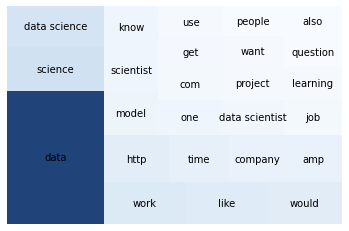

In [20]:
vector_treemap_plotter(ds_posts)
#same data as above - just in a neater visualization that's not as busy as a Word Cloud

In [21]:
#we run our 2 functions for /r/analytics posts:

an_posts = df["cleaned_text"][df["subreddit"]=="analytics"]
vector_barplotter(an_posts, "Top Words in /r/analytics Posts", "words")

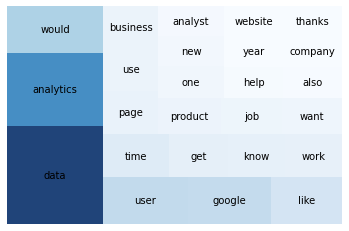

In [22]:
#again same data as graph above, just neater 
vector_treemap_plotter(an_posts)

In [23]:
#joins a list of top words in a first and second series common to both subreddits, 
#labels them correctly according to first and second type subreddits
#and gets rid of NaNs to plot common words on a bar chart

def common_word_plotter(series_1, type_1, series_2, type_2, graph_title, ylabel):
    #series 1 vectorizing first 
    vectorized_series_1 = vectorizer.fit(series_1)
    series_1_df = pd.DataFrame(vectorizer.transform(series_1).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words 
    top_s1_words=series_1_df.sum().sort_values(ascending = False).head(25)
    top_s1_words_df = pd.DataFrame(top_s1_words)
    top_s1_words_df.columns = [type_1]

    #series 2 vectorizing
    vectorized_series_2 = vectorizer.fit(series_2)
    series_2_df = pd.DataFrame(vectorizer.transform(series_2).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words again 
    top_s2_words=series_2_df.sum().sort_values(ascending = False).head(25)
    top_s2_words_df = pd.DataFrame(top_s2_words)
    top_s2_words_df.columns = [type_2]

    #concatenate both along the columns and drop the NaNs
    joined_words_df=pd.concat([top_s1_words_df, top_s2_words_df], axis = 1)
    joined_words_df.dropna(inplace = True)

    fig = px.bar(joined_words_df, orientation='h', title = graph_title,
             labels={"index":ylabel})
    fig.show()

In [24]:
common_word_plotter(ds_posts, "datascience", an_posts, "analytics", "Top Common Words in Both Subreddit Posts", "words")

### Post Analysis:

   1. /r/analytics: we frequently observe unique words like analytics, google, and user in the the analytics subreddits posts.
   2. /r/datascience: data science and scientist, project, model are unique.
   3. Common keywords in both: data, work, job. Nothing outrageously unique, although datascience has significantly more mentions of data.
    
**This honestly doesn't tell us much about the distinguishing features of the two professions.** All this really shows us by inference is that data analysts like to discuss analytics and users, whilst data scientists like to talk about data science, projects, and models. At the same time, both professions are concerned with data and jobs. 

**Are there better insights in the titles of the posts, instead?**

## Titles of Subreddit Posts

In [25]:
#Let's find out. we now do the same visualizations, but for titles. Let's assign the slices again for titles.
ds_titles = df["cleaned_title"][df["subreddit"]=="datascience"]
an_titles = df["cleaned_title"][df["subreddit"]=="analytics"]

In [26]:
#datascience bar chart
vector_barplotter(ds_titles, "Top Words & Bigrams in /r/datascience titles", "titles")

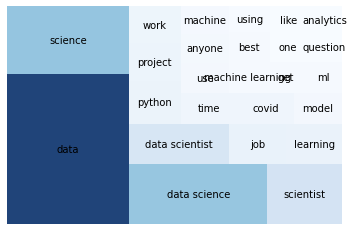

In [27]:
#datascience title treemap
vector_treemap_plotter(ds_titles)

In [28]:
#analytics title bar chart
vector_barplotter(an_titles, "Top Words & Bigrams in /r/analytics titles", "titles")

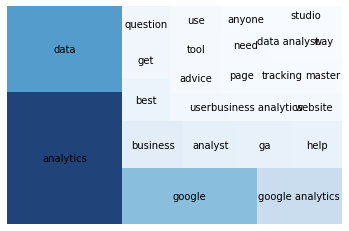

In [29]:
#analytics title treemap
vector_treemap_plotter(an_titles)

In [30]:
#words common to both subreddits
common_word_plotter(ds_titles, "datascience", an_titles, 
                    "analytics", "Top Common Words in Both Subreddit Post Titles", "titles")

### Title Analysis:

Although common keywords in both subreddits' titles unhelpfully include general terms like data, job, and question, there are far more unique title words in each subreddit.

**/r/analytics**: very specific unique words like **google analytics**, ga and **business analytics** appear frequently, as well as website and user. The large occurrence of google analytics and its shorthand term "ga" (not the school!) seems to reflect the importance of that software. It will be helpful for us later to research more on what exactly Google Analytics(GA) is about since it is frequently discussed. 

Given the extra focus on words like **website and user**, we can specifically do research on web analytics and see  why data analysts may be focusing on that more.

**/r/datascience**: for our own chosen profession, there is clearly a stronger focus on words like **python, machine learning ("ml")**, and even **COVID**. With python and machine learning, it's pretty self-explanatory why we focus on these terms. We're literally coding in it right now, but the surprising mention of covid is curious - is it a large focus for data scientists now? These are all major points of research during our Recommendations and Conclusions.



In [52]:
#we see that unique keywords appear more in titles, and it's good enough for us to delve further into those keywords.
#however, we will now move on to modelling, 
#where we will compare extracted keywords from our models, and see if they're any different from the Text EDA here.